In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import class_weight
import random
import pandas as pd
import importlib
import useful_functions
import preprocessing_functions
import Chatgpt_model
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-07-11 14:31:29.838531: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 14:31:29.859484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 14:31:30.219528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-07-11 14:31:31.578509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 14:31:31.578986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 14:31:31.579040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
importlib.reload(useful_functions)
importlib.reload(preprocessing_functions)
importlib.reload(Chatgpt_model)
from useful_functions import *
from preprocessing_functions import *
from Chatgpt_model import *

In [3]:
 # Define the data and model foldes.
data_folder = r"../training_data"
model_folder = r"../model"
wind_size = 6000
verbose = 3

In [4]:
recordings,patient_label,patient_id = create_rec_patient_list(data_folder)
df = build_dataset_df(recordings,patient_id,patient_label,wind_size)
df.head()

,patient_id,recording_type,recording,murmur
0,2530.0,1.0,"[254.62053374948147, 332.41397606699405, -727....",0.0
1,2530.0,1.0,"[20.550841480663475, -18.884669077279337, 152....",0.0
2,2530.0,1.0,"[2296.0082592261, 1161.8953810714854, 106.9764...",0.0
3,2530.0,1.0,"[-1.2132347511973676, -24.042684343382245, -14...",0.0
4,2530.0,1.0,"[219.40892010033423, 106.21377642082071, 296.9...",0.0


In [5]:
#check correctness of dataframe loaded
for i in range(df.shape[0]):
  if len(df["recording"][i]) != 6000:
    print("problem sir")

In [6]:
new_df = df[['patient_id', 'murmur']]
new_df = new_df.drop_duplicates()

In [7]:
new_df = new_df.reset_index(drop=True)

In [8]:
nb_murmur_present = (new_df.loc[new_df['murmur'] == 1]).shape[0]
nb_murmur_absent = (new_df.loc[new_df['murmur'] == 0]).shape[0]
print(nb_murmur_present)
print(nb_murmur_absent)

179
695


In [9]:
new_df

,patient_id,murmur
0,2530.0,0.0
1,9979.0,1.0
2,13918.0,1.0
3,14241.0,1.0
4,14998.0,0.0
...,...,...
869,85340.0,0.0
870,85341.0,0.0
871,85343.0,1.0
872,85345.0,0.0


In [10]:
list_id = new_df['patient_id']
list_label = new_df['murmur']

In [11]:
id_train, id_valtest, label_train, label_valtest = train_test_split(list_id, list_label , test_size=0.4, random_state=42)
id_val, id_test, label_val, label_test = train_test_split(id_valtest, label_valtest , test_size=0.5, random_state=42)

In [12]:
def select_rows(id_list,dframe):
  #for id in list_id:
  sub_df = df.loc[df['patient_id'].isin([int(id) for id in id_list])]
  return sub_df

df_train = select_rows(id_train,df)
df_val = select_rows(id_val,df)
df_test = select_rows(id_test,df)

In [13]:
print("Nb of rows of murmur absent : ",(df_train.loc[df_train['murmur'] == 0]).shape[0])
print("Nb of rows of murmur present : ",(df_train.loc[df_train['murmur'] == 1]).shape[0])

Nb of rows of murmur absent :  11832
Nb of rows of murmur present :  2697


In [14]:
X_train = np.vstack(df_train['recording'])
y_train = np.array(df_train['murmur'])

X_val = np.vstack(df_val['recording'])
y_val = np.array(df_val['murmur'])

X_test = np.vstack(df_test['recording'])
y_test = np.array(df_test['murmur'])

In [15]:
X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
X_test = X_test.reshape(len(X_test),len(X_test[1]),1)

In [16]:
def make_model(input_shape):
    drop_rate = 0.2
    input_layer = tf.keras.layers.Input(shape=(input_shape[0],input_shape[1]))

    x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same",activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(2,padding="same")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    """
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])

2023-07-11 14:31:46.780160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 14:31:46.780271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 14:31:46.780315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 6000, 32)          128       
                                                                 
 batch_normalization (Batch  (None, 6000, 32)          128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 3000, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3000, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3000, 64)          6208  

In [18]:
weights = class_weight.compute_class_weight(  class_weight ='balanced',
                                    classes = np.unique(y_train),
                                    y = y_train)
class_weights = dict(zip(np.unique(y_train), weights))

In [19]:

epochs = 30
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["acc",tf.keras.metrics.AUC(name='auc')],
    weighted_metrics = "acc",
    #loss_weights=weights
)


history = model.fit(
    X_train,
    np.array(y_train),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val,np.array(y_val)),
    class_weight=class_weights,
    verbose=1,
)

Epoch 1/30


2023-07-11 14:31:57.116116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-11 14:31:57.303844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-11 14:31:57.328164: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe58c03b650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-11 14:31:57.328176: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-07-11 14:31:57.342090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-11 14:31:57.451854: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

455/455 [==============================] - 9s 14ms/step - loss: 0.7114 - acc: 0.6228 - auc: 0.6500 - weighted_acc: 0.6134 - val_loss: 0.4755 - val_acc: 0.8029 - val_auc: 0.6921 - val_weighted_acc: 0.8029 - lr: 0.0010
Epoch 2/30
 11/455 [..............................] - ETA: 5s - loss: 0.6301 - acc: 0.6705 - auc: 0.7101 - weighted_acc: 0.6531

/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


455/455 [==============================] - 6s 13ms/step - loss: 0.6479 - acc: 0.6720 - auc: 0.6848 - weighted_acc: 0.6391 - val_loss: 0.5166 - val_acc: 0.8103 - val_auc: 0.7151 - val_weighted_acc: 0.8103 - lr: 0.0010
Epoch 3/30
455/455 [==============================] - 6s 13ms/step - loss: 0.6220 - acc: 0.7086 - auc: 0.7060 - weighted_acc: 0.6593 - val_loss: 0.5367 - val_acc: 0.7923 - val_auc: 0.7245 - val_weighted_acc: 0.7923 - lr: 0.0010
Epoch 4/30
455/455 [==============================] - 6s 13ms/step - loss: 0.6059 - acc: 0.7165 - auc: 0.7273 - weighted_acc: 0.6739 - val_loss: 0.4878 - val_acc: 0.8118 - val_auc: 0.7119 - val_weighted_acc: 0.8118 - lr: 0.0010
Epoch 5/30
455/455 [==============================] - 6s 13ms/step - loss: 0.6005 - acc: 0.7387 - auc: 0.7288 - weighted_acc: 0.6792 - val_loss: 0.4981 - val_acc: 0.8213 - val_auc: 0.7164 - val_weighted_acc: 0.8213 - lr: 0.0010
Epoch 6/30
455/455 [==============================] - 6s 13ms/step - loss: 0.5955 - acc: 0.7346 - a

In [20]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.5315022468566895
Test accuracy: 0.7726151347160339


In [21]:
pred = model.predict(X_test)
print(pred)

152/152 [==============================] - 0s 2ms/step
[[0.09435148]
 [0.16989993]
 [0.2450422 ]
 ...
 [0.3537774 ]
 [0.41688237]
 [0.5285461 ]]


In [22]:
metrics_list = model.evaluate(X_test,y_test)

152/152 [==============================] - 0s 2ms/step - loss: 0.5315 - acc: 0.7726 - auc: 0.7248 - weighted_acc: 0.7726


In [23]:
print(metrics_list)

[0.5315022468566895, 0.7726151347160339, 0.7248320579528809, 0.7726151347160339]


In [24]:
def check_max_pred(prd):
  max=0
  for i in prd:
    if i[0] > max:
      max = i[0]
  print(max)

In [25]:
check_max_pred(pred)

0.99984765


In [26]:
list_patient_rows = list(df_test.groupby(['patient_id'])['patient_id'].count())

In [27]:
def cumulative(lists): 
    cu_list = [] 
    length = len(lists) 
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)] 
    return cu_list[1:]

In [28]:
pred_groupby_patient = np.split(pred,cumulative(list_patient_rows))
pred_groupby_patient = pred_groupby_patient[:-1]

df_test = df_test.astype({'murmur':'int'})
y_test_grouped = df_test[['patient_id','murmur']].drop_duplicates()['murmur'].to_list()

In [29]:
def mean_pred(prediction):
  pred = []
  for i in prediction:
    lst = [ j[0] for j in i]
    avg = sum(lst)/len(lst)
    if avg > 0.5:
      pred.append(1)
    else:
      pred.append(0)
  return pred

def majority_pred(prediction):
  pred = []
  for i in prediction:
    lst = [ j[0] for j in i]
    if (sum(elem > 0.5 for elem in lst)) > (len(lst)/2):
      pred.append(1)
    else:
      pred.append(0)
  return pred


In [30]:
pred1 = mean_pred(pred_groupby_patient)
pred2 = majority_pred(pred_groupby_patient)



In [31]:
print(pred1)
print(pred2)
print(y_test_grouped)
print("Accuracy score of mean_pred : ",accuracy_score(pred1 , y_test_grouped))
print("Accuracy score of majority_pred : ",accuracy_score(pred2 , y_test_grouped))

[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [32]:
print("Weighted accuracy on test set : ",balanced_accuracy_score(pred1, y_test_grouped))

Weighted accuracy on test set :  0.7591069330199764


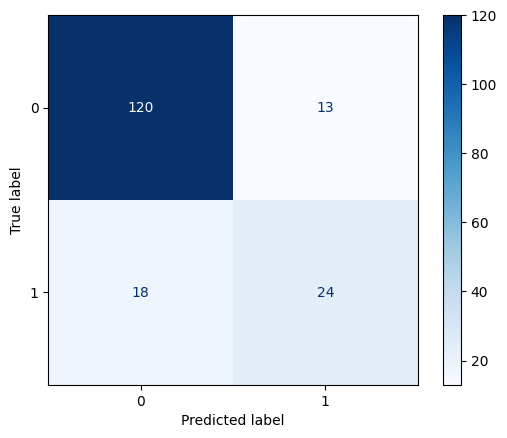

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred1,
                                        cmap='Blues', normalize = None)

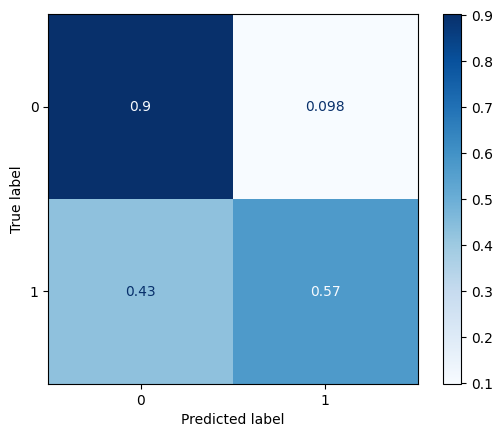

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred1,
                                        cmap='Blues', normalize = 'true')